* Use preprocessed features to train a predictive model
* First construct a function to implement cross validation
* Then set a benchmark for model evaluation with randomized data and logistic regression
* Finally, fit and evaluate logistic regression, bootstrapped balanced datasets, as well as a ensemble method still based on logistic regression

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# load in the data set
train_raw = pd.read_csv('train.csv')
muted = pd.read_csv('/Users/yizhao/Documents/Second_capstone/muted_data.csv')


In [3]:
# define predictors and predicted variable
less_ft = muted.dropna(axis=1)


### Test sensitivity to definition of categorical variabes

In [ ]:
def transf_dat(muted, N):
    muted = muted.drop(['var3','var36', 'TARGET'], axis = 1)
    # remove variables with missing values and the target column
    muted = muted.set_index(["ID"]) 
    for field in list(muted.columns):
    
        n_uniq = np.unique(muted[field]).size # get the number of unique values
        if n_uniq == 1:
            muted = muted.drop(field,axis = 1) # drop fields with only 1 unique value,m,,,,,,

        if n_uniq > 2 and n_uniq <=N:
            # consider the column as a categorical variable
            muted = pd.concat([muted, 
                               pd.get_dummies(muted[field], prefix=field).iloc[:,:-1]], 
                              axis=1)
            muted = muted.drop(field, axis=1)
    return muted

### Set up functions for cross-validation

In [8]:
seed = 1
# use stratified kfold to ensure that there are 1 and 0 in each fold
kfold = cross_validation.StratifiedKFold(train_raw.TARGET, 
                                         n_folds=5,  # five fold cross validation
                                         random_state=seed) 

In [50]:
def cv_score(k, X, y, classifier): # X is a data frame, y is a list
    kfold = model_selection.StratifiedKFold(n_splits= k)
    scores = 0.
    for train, test in kfold.split(X, y):
        probas_t = classifier.fit(X.iloc[train,:], y[train]).predict_proba(X.iloc[test,:])
        sc = metrics.roc_auc_score(y[test], probas_t[:,1])
        scores += sc
    return scores/k


### Apply Cross validated Machine Learning

In [73]:
# load in libraries for ML
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation #StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import model_selection # StratifiedKFold


from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB

from sklearn.pipeline import Pipeline
from pandas_ml import ConfusionMatrix

### Construct a benchmark null model

In [5]:
rand_index = np.random.randint(less_ft.shape[0], size = less_ft.shape[0])
randomized = less_ft.iloc[rand_index,:] # randomized data frame

In [7]:
y = train_raw[['TARGET']].values.ravel()

Xlr, Xtestlr, y_lr, y_testlr = train_test_split(randomized, 
                                                y,
                                                random_state=5)

scale = MinMaxScaler()
X_train = scale.fit_transform(Xlr) # scale all predictor variables
X_test = scale.fit_transform(Xtestlr)

LG = LogisticRegression(C=0.1)
LG.fit(X_train, y_lr)

pred_train = LG.predict(X_train)
pred_test = LG.predict(X_test)

metrics.roc_auc_score(y_testlr, LG.predict_proba(X_test)[:,1])

0.48363682517536721

In [63]:
ConfusionMatrix(y_true = y_testlr, y_pred = pred_test)

Predicted      0  1  __all__
Actual                      
0          18300  0    18300
1            705  0      705
__all__    19005  0    19005

In [51]:
# use cross validation to find an average value of the ROC AUC
results = cv_score(5,  randomized, y, LogisticRegression(C=0.1))
print('Null model no transformation Logistic Regression\n mean ROC AUC score: \n',
      results)

Null model no transformation Logistic Regression
 mean ROC AUC score: 
 0.49807360146


### Logistic Rression on actual data set

In [53]:
print('Logistic Regression\n mean ROC AUC score: \n',
      cv_score(5,  less_ft, y, LogisticRegression(C=0.1))
)

Logistic Regression
 mean ROC AUC score: 
 0.599080519934


* The result above is better than the null model
* Now add a MinMaxScaler to improve the model

In [54]:
pipe_LG_scaled = Pipeline([
    ('minmax', MinMaxScaler()),
    ('LG', LogisticRegression(C=0.1))  
])
print('MinMax scalled Logistic Regression\n mean ROC AUC score: \n',
      cv_score(5,  less_ft, y, pipe_LG_scaled)
      )

MinMax scalled Logistic Regression
 mean ROC AUC score: 
 0.786704261508


In [98]:
# run one individual logsitic regression to see the model performance in recall
X = MinMaxScaler().fit_transform(less_ft)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= seed)

LG = LogisticRegression(C=0.1)
LG.fit(X_train, y_train)

pred_train = LG.predict(X_train)
pred_test = LG.predict(X_test)

prob_test = LG.predict_proba(X_test)
print("Scaled Logistic regression AUC score: "
    ,metrics.roc_auc_score(y_true = y_test,  y_score = prob_test[:,1]))

ConfusionMatrix(y_true = y_test, y_pred = pred_test)

Scaled Logistic regression AUC score:  0.777781223847


Predicted      0  1  __all__
Actual                      
0          18256  2    18258
1            747  0      747
__all__    19003  2    19005

/Users/yizhao/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yizhao/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


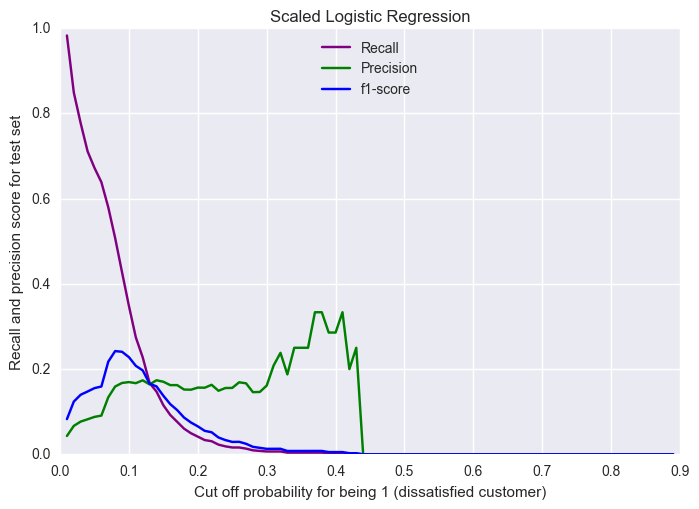

In [99]:
cut_off = np.arange(0.01,0.9,0.01)

recall_test = [metrics.recall_score(y_pred= prob_test[:,1]>x, 
                            y_true = y_test) for x in cut_off]
precision_test = [metrics.precision_score(y_pred= prob_test[:,1]>x, 
                            y_true = y_test) for x in cut_off]
f1_test = [metrics.f1_score(y_pred= prob_test[:,1]>x, 
                            y_true = y_test) for x in cut_off]
fig, ax = plt.subplots()
ax.plot(cut_off, recall_test, label = 'Recall', color = 'purple')
ax.plot(cut_off, precision_test, color = 'green', label = 'Precision')
ax.plot(cut_off, f1_test, color = 'blue', label = 'f1-score')
legend = ax.legend(loc='upper center', shadow=True)
ax.set_title('Scaled Logistic Regression')
ax.set_xlabel('Cut off probability for being 1 (dissatisfied customer)')
ax.set_ylabel('Recall and precision score for test set')
plt.show()

In [100]:
ConfusionMatrix(y_true = y_test, y_pred = prob_test[:,1]>0.08)

Predicted  False  True  __all__
Actual                         
False      16255  2003    18258
True         368   379      747
__all__    16623  2382    19005

* The MinMaxScale significantly improved the model
* Try Chi2 feature selection to see if there is further improvment

In [55]:
pipe_LG_chi2 = Pipeline([
    ('minmax', MinMaxScaler()),
    ('kBest', SelectKBest(chi2, k = 100)),
    ('LG', LogisticRegression(C=0.1))  
])

print('MinMax scalled Logistic Regression\n mean ROC AUC score: \n',
      cv_score(5,  less_ft, y, pipe_LG_chi2))

MinMax scalled Logistic Regression
 mean ROC AUC score: 
 0.778433472633


* There was not any improvement. Actually, the AUC score was even lower. 

#### Test the sensitivity of results to the threshold of unique values for categorical versus numerical variables

In [70]:
raw = train_raw.drop(['var3','var36', 'TARGET'], axis = 1)
print('Raw training data\n scalled Logistic Regression\n mean ROC AUC score: \n',
      cv_score(5,  raw, y, pipe_LG_scaled)
      )

/Users/yizhao/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


Raw training data
 scalled Logistic Regression
 mean ROC AUC score: 
 0.783026687606


In [65]:
uniq_10 = transf_dat(train_raw, 10)

In [67]:
uniq_10.shape

(76020, 631)

In [66]:
print('Categorical variables defined as having less than 10 unique values\n scalled Logistic Regression\n mean ROC AUC score: \n',
      cv_score(5,  uniq_10, y, pipe_LG_scaled)
      )

Categorical variables defined as having less than 10 unique values
 scalled Logistic Regression
 mean ROC AUC score: 
 0.784806125663


In [68]:
uniq_30 = transf_dat(train_raw, 30)
uniq_30.shape

(76020, 1156)

In [69]:
print('Categorical variables defined as having less than 30 unique values\n scalled Logistic Regression\n mean ROC AUC score: \n',
      cv_score(5,  uniq_30, y, pipe_LG_scaled)
      )

Categorical variables defined as having less than 30 unique values
 scalled Logistic Regression
 mean ROC AUC score: 
 0.785973809131


* It seems that there difference among choices of categorical variables did not make a significant difference
* Even if using the raw dataset without distinguishing any categorical versus not or removing features with only one unique value, the resulting auc score is lower by 0.003 compared to transforming an arbitrarily defined set of categorical variables as dummy variables. 

### Naive Bayes

In [118]:
print('Naive Bayes\n mean ROC AUC score: \n',
      cv_score(5,  less_ft, y, BernoulliNB()))

Naive Bayes
 mean ROC AUC score: 
 0.712689622542


In [74]:
pipe_NB = Pipeline([
    ('minmax', MinMaxScaler()),
    ('nb', BernoulliNB())  
])

print('MinMax scalled Naive Bayes\n mean ROC AUC score: \n',
      cv_score(5,  less_ft, y, pipe_NB))


MinMax scalled Naive Bayes
 mean ROC AUC score: 
 0.703902264811


In [76]:
pipe_NB_chi2 = Pipeline([
    ('minmax', MinMaxScaler()),
    ('kBest', SelectKBest(chi2, k = 100)),
    ('nb', BernoulliNB())  
])

print('MinMax scalled chi2 top 100 features\n Bernouli Naive Bayes\n mean ROC AUC score: \n',
      cv_score(5,  less_ft, y, pipe_NB_chi2))

MinMax scalled chi2 top 100 features
 Bernouli Naive Bayes
 mean ROC AUC score: 
 0.713750329496


### Decesion tree based classifiers

In [114]:
# simple random forest classifier
print('Random Forest on original dataset\n mean ROC AUC score: \n',
      cv_score(5,  raw, y, RandomForestClassifier()))

print('\nRandom Forest \n mean ROC AUC score: \n',
      cv_score(5,  less_ft, y, RandomForestClassifier()))


print('\nMinMax scalled RandomForestClassifier\n mean ROC AUC score: \n',
      cv_score(5,  less_ft, y, Pipeline([
    ('minmax', MinMaxScaler()),
    ('RF', RandomForestClassifier())  
])))

Random Forest on original dataset
 mean ROC AUC score: 
 0.693697681224

Random Forest 
 mean ROC AUC score: 
 0.686270439471

MinMax scalled RandomForestClassifier
 mean ROC AUC score: 
 0.6700023768


In [117]:
# gradient boosting without any scaling
print('GradientBoostingClassifier\n mean ROC AUC score: \n',
      cv_score(5,  less_ft, y, GradientBoostingClassifier()  ))

GradientBoostingClassifier
 mean ROC AUC score: 
 0.707529186673


In [57]:
# Gradient Boosting classifier
pipe_boost = Pipeline([
    ('minmax', MinMaxScaler()),
    ('G', GradientBoostingClassifier())  
])

print('MinMax scalled GradientBoostingClassifier\n mean ROC AUC score: \n',
      cv_score(5,  less_ft, y, pipe_boost))

MinMax scalled Logistic Regression
 mean ROC AUC score: 
 0.773383059245


* Again, the result was worse than a simple logistic regression
* This model's default has max_depth = 3. Try some other numbers to see if the results improve

In [58]:

print('MinMax scalled Gradient Boosting Classifier (max_depth = 2)\n mean ROC AUC score: \n',
      cv_score(5,  less_ft, y, 
              Pipeline([
                    ('minmax', MinMaxScaler()),
                    ('G', GradientBoostingClassifier(max_depth = 2))  
                ])
              ))

MinMax scalled Gradient Boosting Classifier (max_depth = 2)
 mean ROC AUC score: 
 0.726656727175


* A smaller max_depth led to a worse result
* Try larger max_depth, or allow deeper learning in the trees to account for interactions among features

In [59]:
print('MinMax scalled Gradient Boosting Classifier (max_depth = 4)\n mean ROC AUC score: \n',
      cv_score(5,  less_ft, y, 
              Pipeline([
                    ('minmax', MinMaxScaler()),
                    ('LG', GradientBoostingClassifier(max_depth = 4))  
                ])
              ))
print('MinMax scalled Gradient Boosting Classifier (max_depth = 5)\n mean ROC AUC score: \n',
      cv_score(5,  less_ft, y, 
              Pipeline([
                    ('minmax', MinMaxScaler()),
                    ('G', GradientBoostingClassifier(max_depth = 5))  
                ])
              ))

MinMax scalled Gradient Boosting Classifier (max_depth = 4)
 mean ROC AUC score: 
 0.757331178641
MinMax scalled Gradient Boosting Classifier (max_depth = 5)
 mean ROC AUC score: 
 0.762505814474


In [61]:
print('MinMax scalled Gradient Boosting Classifier (max_depth = 10)\n mean ROC AUC score: \n',
      cv_score(5,  less_ft, y, 
              Pipeline([
                    ('minmax', MinMaxScaler()),
                    ('G', GradientBoostingClassifier(max_depth = 10))  
                ])
              ))

MinMax scalled Gradient Boosting Classifier (max_depth = 10)
 mean ROC AUC score: 
 0.728726317078


* Increasing the number of maximum depth in boosted regression trees did not lead to better result.
* We conclude to use the simple logistic regression on MinMaxScaled features

In [115]:
print('XGBoost\n mean ROC AUC score: \n',
      cv_score(5,  less_ft, y, XGBClassifier(max_depth = 3)))

XGBoost
 mean ROC AUC score: 
 0.831932077938


In [77]:
pipe_xgb = Pipeline([
    ('minmax', MinMaxScaler()),
    ('xgb', XGBClassifier(max_depth = 3))  
])

print('MinMax scalled XGBoost\n mean ROC AUC score: \n',
      cv_score(5,  less_ft, y, pipe_xgb))

MinMax scalled XGBoost
 mean ROC AUC score: 
 0.831932077938


* This model appears to be the best performing 
* Look at one run's result, especially the confusion matrix and recall, precision, f1-score

In [101]:
X = MinMaxScaler().fit_transform(less_ft)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= seed)

xgb = XGBClassifier(max_depth= 3)
xgb.fit(X_train, y_train)

pred_train = xgb.predict(X_train)
pred_test = xgb.predict(X_test)

prob_test = xgb.predict_proba(X_test)
print("AUC score: "
    ,metrics.roc_auc_score(y_true = y_test,  y_score = prob_test[:,1]))

ConfusionMatrix(y_true = y_test, y_pred = pred_test)

AUC score:  0.835076494681


Predicted      0  1  __all__
Actual                      
0          18257  1    18258
1            746  1      747
__all__    19003  2    19005

/Users/yizhao/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yizhao/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


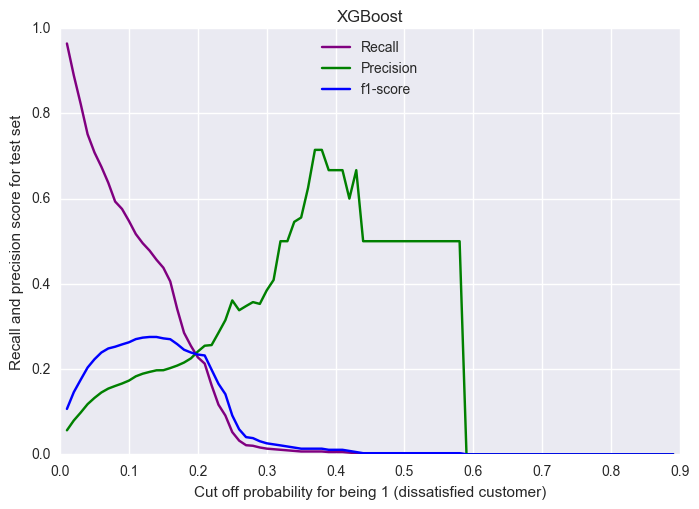

In [102]:
cut_off = np.arange(0.01,0.9,0.01)

recall_test = [metrics.recall_score(y_pred= prob_test[:,1]>x, 
                            y_true = y_test) for x in cut_off]
precision_test = [metrics.precision_score(y_pred= prob_test[:,1]>x, 
                            y_true = y_test) for x in cut_off]
f1_test = [metrics.f1_score(y_pred= prob_test[:,1]>x, 
                            y_true = y_test) for x in cut_off]
fig, ax = plt.subplots()
ax.plot(cut_off, recall_test, label = 'Recall', color = 'purple')
ax.plot(cut_off, precision_test, color = 'green', label = 'Precision')
ax.plot(cut_off, f1_test, color = 'blue', label = 'f1-score')
legend = ax.legend(loc='upper center', shadow=True)
ax.set_title('XGBoost')
ax.set_xlabel('Cut off probability for being 1 (dissatisfied customer)')
ax.set_ylabel('Recall and precision score for test set')
plt.show()

In [103]:
ConfusionMatrix(y_true = y_test, y_pred = prob_test[:,1]>0.13)

Predicted  False  True  __all__
Actual                         
False      16769  1489    18258
True         390   357      747
__all__    17159  1846    19005

* Recall always increases with a decreasing probability threshold for predicting as positive.
* The number of False Positives is less alarming, because trying to improve service to those that were not going to leave wouldn't hurt. Falsely ignoring the dissatisfied customers, however, would be much more hurtful. 
* The recall score at a highest F1-score of this XGBoost model is 0.478, which is slightly lower than the recall of 0.507 in Logistic Regression with an optimal threshold of 0.08. 
Yet, this XGBoost model does have a higher precision, and a higher f-1 score. For the purpose of reducing False Negatives, however, logistic regression was still slighly better.

### Bootstrap the training set to ensure balanced positive and negative observations

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= seed)

# divid the training set into 0 and 1
y_train_pos = y_train[y_train == 1] # only dissatisfied customers
X_train_pos = X_train[y_train == 1]

y_train_neg = y_train[y_train == 0] # subset the training set to only those with satisfied customers
X_train_neg = X_train[y_train == 0]

reps = round(X_train.shape[0]/2)

pos_i = np.random.choice(X_train_pos.shape[0], reps)
neg_i = np.random.choice(X_train_neg.shape[0], reps)

X_res = np.concatenate([X_train_pos[pos_i] , 
                        X_train_neg[neg_i]])
            # pd.concat([X_train_pos.iloc[pos_i, :], 
         #          X_train_neg.iloc[neg_i, :]], axis = 0)
y_res = np.concatenate([y_train_pos[pos_i] , 
                        y_train_neg[neg_i]])

In [105]:
LG = LogisticRegression(C=0.1)
LG.fit(X_res, y_res)

pred_train = LG.predict(X_res)
pred_test = LG.predict(X_test)

prob_test = LG.predict_proba(X_test)
print("Bootstrapped Logistic Regression AUC score: "
    ,metrics.roc_auc_score(y_true = y_test,  y_score = prob_test[:,1]))

ConfusionMatrix(y_true = y_test, y_pred = pred_test)

Bootstrapped Logistic Regression AUC score:  0.783211936364


Predicted      0     1  __all__
Actual                         
0          12281  5977    18258
1            202   545      747
__all__    12483  6522    19005

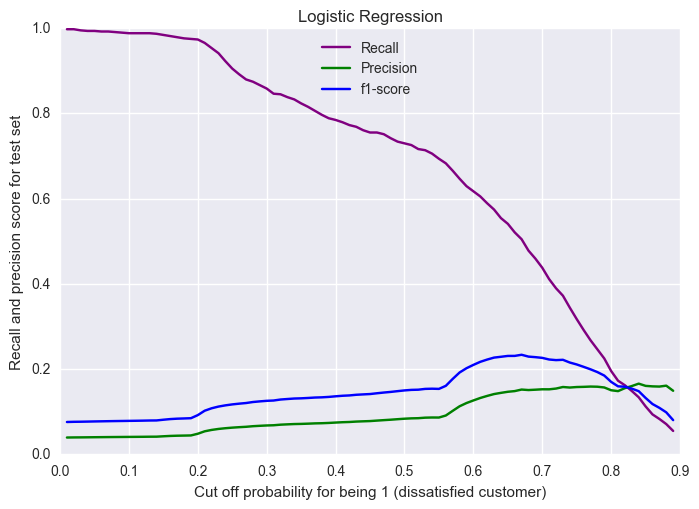

In [106]:
prob_test = LG.predict_proba(X_test)

recall_test = [metrics.recall_score(y_pred= prob_test[:,1]>x, 
                            y_true = y_test) for x in cut_off]
precision_test = [metrics.precision_score(y_pred= prob_test[:,1]>x, 
                            y_true = y_test) for x in cut_off]
f1_test = [metrics.f1_score(y_pred= prob_test[:,1]>x, 
                            y_true = y_test) for x in cut_off]
fig, ax = plt.subplots()
ax.plot(cut_off, recall_test, label = 'Recall', color = 'purple')
ax.plot(cut_off, precision_test, color = 'green', label = 'Precision')
ax.plot(cut_off, f1_test, color = 'blue', label = 'f1-score')
legend = ax.legend(loc='upper center', shadow=True)
ax.set_title('Logistic Regression')
ax.set_xlabel('Cut off probability for being 1 (dissatisfied customer)')
ax.set_ylabel('Recall and precision score for test set')
plt.show()

In [110]:
ConfusionMatrix(y_true = y_test, y_pred = prob_test[:,1]>0.66)

Predicted  False  True  __all__
Actual                         
False      16025  2233    18258
True         358   389      747
__all__    16383  2622    19005

* Obtained about the same level of F-1 score as the Logistic Regression model without any bootstrap
* Recall is higher with a corresponding loss in having a higher number of False Positives.